In [30]:
import torchmetrics

In [31]:
from datasets import load_dataset
import numpy as np

transformer_name = "microsoft/beit-base-patch16-224"


train_dataset = load_dataset("DGE_training", data_dir="*/", split="train")#.shuffle()
#train_dataset = load_dataset("DGE_val", data_dir="*/", split='test')
#train_dataset = load_dataset("DGE_test", data_dir="*/", split='test')
#train_dataset = train_dataset.train_test_split(test_size=0.2)
#print(train_dataset["train"][0])
labels = train_dataset.features["label"].names




# food = load_dataset("food101", split="train[:5000]")
# food = food.train_test_split(test_size=0.2)
# food["train"][0]
# labels = food["train"].features["label"].names
# label2id, id2label = dict(), dict()
# for i, label in enumerate(labels):
#     label2id[label] = str(i)
#     id2label[str(i)] = label
# id2label[str(79)]

from transformers import AutoFeatureExtractor, BeitFeatureExtractor

feature_extractor = BeitFeatureExtractor.from_pretrained(transformer_name)



Resolving data files: 100%|██████████| 476/476 [00:00<00:00, 238017.25it/s]
Using custom data configuration DGE_training-1a4881cf19cc1a09
Reusing dataset imagefolder (C:\Users\zacha\.cache\huggingface\datasets\imagefolder\DGE_training-1a4881cf19cc1a09\0.0.0\0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff)


In [32]:
# print(np.min(train_dataset["train"][:]['label']))
# print(np.max(train_dataset["train"][:]['label']))

In [33]:
# print(food)
# print(food['train'])
# print(train_dataset)
# print(train_dataset['train'])

In [34]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_transforms = Compose([RandomResizedCrop(feature_extractor.size), ToTensor(), normalize])

In [35]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

#food = food.with_transform(transforms)
train_dataset = train_dataset.with_transform(transforms)

from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [36]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer, BeitForImageClassification
from datasets import load_metric

model = BeitForImageClassification.from_pretrained(
    transformer_name,
    num_labels=5,
    ignore_mismatched_sizes=True,
    # id2label=id2label,
    # label2id=label2id,
)

device = 'cuda'
model = model.to(device)

# def compute_metrics(eval_pred):
#     metrics = ["accuracy", "recall", "precision", "f1"] #List of metrics to return
#     metric={}
#     for met in metrics:
#        metric[met] = load_metric(met)
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     metric_res={}
#     for met in metrics:
#        metric_res[met]=metric[met].compute('macro', predictions=predictions, references=labels)[met]
#     return metric_res

from datasets import load_metric
metric = load_metric('accuracy')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

model.cuda()

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BeitForImageClassification(
  (beit): BeitModel(
    (embeddings): BeitEmbeddings(
      (patch_embeddings): BeitPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BeitEncoder(
      (layer): ModuleList(
        (0): BeitLayer(
          (attention): BeitAttention(
            (attention): BeitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (relative_position_bias): BeitRelativePositionBias()
            )
            (output): BeitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (int

In [37]:
import torch
from torch import nn
from sklearn.utils import class_weight
import pandas as pd
import numpy as np

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        train_df = pd.read_csv('train_data.csv',dtype=str)
        class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_df['class']), y =train_df['class'])
        loss_fct = nn.CrossEntropyLoss(weight=torch.cuda.FloatTensor(class_weights))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [38]:
from sklearn.utils import class_weight
import pandas as pd
import numpy as np

train_df = pd.read_csv('train_data.csv',dtype=str)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_df['class']), y =train_df['class'])
print(class_weights)

[5.95       0.952      0.43272727 0.7616     6.34666667]


In [39]:
# from torchsummary import summary
# summary(model, (3, 224, 224))


In [40]:
from torchvision import datasets

#training_dataset_pt = datasets.ImageFolder(root="DGE_training", transform=transforms)
dataset_size = len(train_dataset[:]['label'])
train_count = int(dataset_size * 0.7)
val_count = dataset_size - train_count
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_dataset, [train_count, val_count])

#print(train_dataset[0])
import numpy as np 

#y_train_indices = train_dataset["train"].indices

y_train = train_dataset[:]['label']

class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)

sampler = torch.utils.data.WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, sampler=sampler)


In [41]:
print(train_dataset[:]['label'])

[2, 3, 3, 2, 3, 2, 2, 2, 3, 3, 0, 3, 3, 2, 1, 1, 2, 1, 2, 2, 2, 3, 2, 1, 2, 1, 2, 2, 1, 2, 3, 3, 3, 2, 3, 3, 1, 1, 3, 1, 3, 3, 3, 2, 3, 3, 2, 0, 1, 2, 3, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 3, 2, 2, 2, 2, 1, 2, 1, 3, 1, 3, 3, 0, 3, 2, 3, 1, 2, 1, 0, 1, 1, 2, 2, 2, 2, 2, 3, 3, 2, 1, 4, 3, 2, 1, 1, 1, 2, 2, 2, 1, 2, 3, 3, 3, 3, 2, 2, 3, 1, 3, 2, 3, 1, 3, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 3, 4, 2, 2, 1, 1, 1, 2, 1, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 3, 4, 2, 1, 3, 1, 1, 2, 3, 3, 2, 1, 2, 2, 3, 3, 2, 0, 2, 2, 3, 3, 2, 3, 3, 1, 2, 1, 1, 2, 2, 2, 1, 3, 2, 2, 1, 3, 3, 2, 2, 2, 2, 2, 2, 3, 4, 3, 1, 2, 3, 3, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3, 1, 3, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 3, 3, 1, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2, 1, 2, 1, 3, 2, 3, 2, 2, 1, 3, 1, 1, 3, 2, 2, 4, 2, 2, 3, 3, 2, 1, 0, 2, 2, 0, 3, 2, 2, 1, 2, 1, 2, 0, 3, 2, 2, 2, 2, 4, 3, 2, 1, 2, 2, 3, 4, 0, 3, 1, 1, 3, 3, 2, 2, 2, 3, 3, 0, 2, 3, 1, 4, 2, 2, 3, 1, 1, 2, 2, 4, 3, 3, 2, 2, 2, 2, 2, 2, 1, 2, 3, 2, 2, 3]


In [42]:
from transformers import AdamW
from datasets import load_metric


model.train()

optim = AdamW(model.parameters(), lr=5e-5)
size = len(train_dataloader.dataset)

train_df = pd.read_csv('train_data.csv',dtype=str)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_df['class']), y =train_df['class'])
loss_fct = nn.CrossEntropyLoss(weight=torch.cuda.FloatTensor(class_weights))
#loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

# acc_metric = torchmetrics.Accuracy(num_classes=5, average='macro')
# precision_metric = torchmetrics.Precision(num_classes=5, average='macro')
# recall_metric = torchmetrics.Recall(num_classes=5, average='macro')



for epoch in range(200):
    metric = load_metric('accuracy')
    for batch in train_dataloader:
        optim.zero_grad()
        #input_ids = batch['input_ids'].to(device)
        #attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(batch['pixel_values'].type('torch.cuda.FloatTensor'), labels=labels)
        loss = loss_fct(outputs[1], labels)
        #loss = loss_fct(outputs[1].view(-1, model.config.num_labels), labels.view(-1)) #difference between this and the above line?
        #loss = outputs[0]
        #loss.backward()                              #Do I need this loss.backward? Does my loss function do that already?
        optim.step()
        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        metric.add_batch(predictions=np.argmax(outputs[1].cpu().detach().numpy(), axis=-1), references=labels)
    print(epoch)
    print(metric.compute())
    #print(metric)

c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


0
{'accuracy': 0.14414414414414414}
1
{'accuracy': 0.14114114114114115}
2
{'accuracy': 0.15915915915915915}
3
{'accuracy': 0.19519519519519518}
4
{'accuracy': 0.15315315315315314}
5
{'accuracy': 0.16516516516516516}
6
{'accuracy': 0.12912912912912913}
7
{'accuracy': 0.16216216216216217}
8
{'accuracy': 0.16516516516516516}
9
{'accuracy': 0.15915915915915915}
10
{'accuracy': 0.16216216216216217}
11
{'accuracy': 0.15315315315315314}
12
{'accuracy': 0.13513513513513514}
13
{'accuracy': 0.15615615615615616}
14
{'accuracy': 0.14414414414414414}
15
{'accuracy': 0.17417417417417416}
16
{'accuracy': 0.15915915915915915}
17
{'accuracy': 0.16516516516516516}
18
{'accuracy': 0.17417417417417416}
19
{'accuracy': 0.14714714714714713}
20
{'accuracy': 0.15615615615615616}
21
{'accuracy': 0.14714714714714713}
22
{'accuracy': 0.16816816816816818}
23
{'accuracy': 0.14414414414414414}
24
{'accuracy': 0.13513513513513514}
25
{'accuracy': 0.14714714714714713}
26
{'accuracy': 0.13513513513513514}
27
{'accura

In [43]:
print(outputs[1])
# print(labels)
# print(model.config.num_labels)
# print(outputs[1].view(-1, model.config.num_labels))

# print(outputs[1])
# print(batch)

pred = np.argmax(outputs[1].cpu().detach().numpy(), axis=-1) 
print(pred)

tensor([[-0.4633,  0.4159,  1.0280,  0.3456,  0.8690],
        [-0.5470,  0.6106,  1.5428,  0.0613,  0.8497],
        [-0.7136,  0.6064,  0.9738,  1.0512,  1.3467],
        [-0.6677,  0.3204,  1.5986, -0.6328,  1.5374],
        [-0.9205,  0.8382,  1.3102,  0.1464,  1.3542],
        [-0.9995,  0.3725,  0.6428,  0.4840,  1.3246],
        [-1.1717, -0.4074,  0.7591, -0.5021,  0.7506],
        [-1.3107,  0.7272,  1.9333, -0.9098,  0.5535],
        [ 0.2494,  1.0322,  0.7350, -0.4661,  0.1094],
        [-0.4558, -0.2620,  1.7390, -1.6217,  0.9895],
        [-0.7108, -0.5093,  1.3565, -0.3074,  0.9590],
        [-0.9799,  0.1571,  1.1919,  0.7901,  1.0418],
        [-0.2123,  0.9098,  1.3497, -0.4022,  0.4971]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
[2 2 4 2 4 4 2 2 1 2 2 2 2]


In [44]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    evaluation_strategy="epoch",
    num_train_epochs=50,
    fp16=False,
    #save_steps=10,
    #eval_steps=10,
    #logging_steps=10,
    learning_rate=2e-7,
    save_total_limit=2,
    remove_unused_columns=False,
)
#cudnn.benchmark = True
trainer = CustomTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset["train"],
    eval_dataset=train_dataset["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

train_results = trainer.train()

TypeError: list indices must be integers or slices, not str

In [ ]:
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)

***** train metrics *****
  epoch                    =       50.0
  train_loss               =     1.3301
  train_runtime            = 0:04:17.95
  train_samples_per_second =     73.656
  train_steps_per_second   =      4.652


In [ ]:
test_dataset = load_dataset("DGE_test", data_dir="*/", split="train")
#train_dataset = load_dataset("DGE_val", data_dir="*/", split='test')
#train_dataset = load_dataset("DGE_test", data_dir="*/", split='test')
test_dataset = test_dataset.train_test_split(test_size=0.01)
test_dataset["train"][0]
labels = test_dataset["train"].features["label"].names
test_dataset = test_dataset.with_transform(transforms)

Resolving data files: 100%|██████████| 2950/2950 [00:00<00:00, 20624.64it/s]
Using custom data configuration DGE_test-14758c97f2c96edf
Reusing dataset imagefolder (C:\Users\zacha\.cache\huggingface\datasets\imagefolder\DGE_test-14758c97f2c96edf\0.0.0\0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff)
Loading cached split indices for dataset at C:\Users\zacha\.cache\huggingface\datasets\imagefolder\DGE_test-14758c97f2c96edf\0.0.0\0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff\cache-554718d9831d2184.arrow and C:\Users\zacha\.cache\huggingface\datasets\imagefolder\DGE_test-14758c97f2c96edf\0.0.0\0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff\cache-98c7a26f94069e47.arrow


In [ ]:
# metrics = trainer.evaluate(test_dataset["train"])
# trainer.log_metrics("eval", metrics)
# trainer.save_metrics("eval", metrics)

# from transformers import ImageClassificationPipeline

# classifier = ImageClassificationPipeline(model=model, tokenizer=feature_extractor, framework="pt", num_workers=10, batch_size=16, device=0)

# classifier(test_dataset, batch_size=16)




In [ ]:
predictions = trainer.predict(test_dataset["train"])

***** Running Prediction *****
  Num examples = 2920
  Batch size = 8
100%|██████████| 365/365 [00:21<00:00, 17.16it/s]


In [ ]:
print(predictions)
y_pred = np.argmax(predictions.predictions, axis=-1)
y_true = predictions.label_ids
print(y_pred)
print(y_true)

PredictionOutput(predictions=array([[-0.9374621 ,  0.7268996 ,  0.86397487, -0.6530805 , -0.48267034],
       [ 0.09381264,  0.14224368, -0.40154248, -1.0393232 ,  0.5632388 ],
       [ 0.11771351,  0.94170356,  0.36834213, -1.3381771 ,  0.4872938 ],
       ...,
       [ 0.6386661 ,  0.60770094,  0.30931827,  0.85920656, -0.22804642],
       [-0.96552956,  1.1937306 ,  0.36758405, -0.9231657 , -0.46966907],
       [ 0.4315107 ,  1.0482173 ,  1.2298714 , -0.6966719 ,  0.2938264 ]],
      dtype=float32), label_ids=array([3, 2, 2, ..., 2, 2, 2], dtype=int64), metrics={'test_loss': 1.6232883930206299, 'test_accuracy': 0.16712328767123288, 'test_runtime': 21.5008, 'test_samples_per_second': 135.809, 'test_steps_per_second': 16.976})
[2 4 1 ... 3 1 2]
[3 2 2 ... 2 2 2]


<AxesSubplot:>

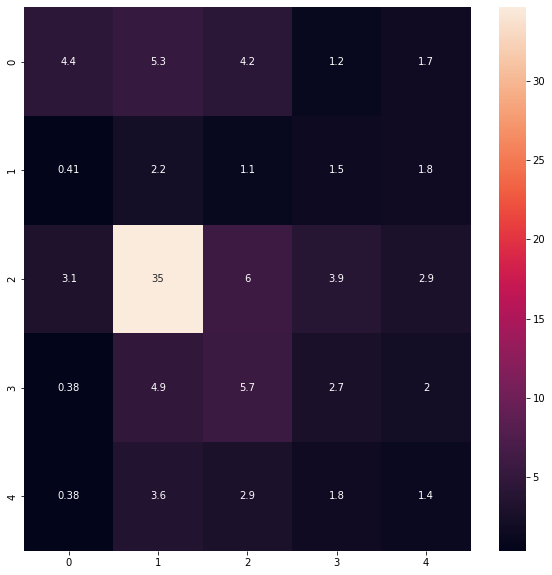

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
cf_matrix = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *100, index = range(0, 5),
                     columns = range(0, 5))


plt.figure(figsize=(10,10))
sn.heatmap(df_cm, annot=True)

In [ ]:
import sklearn
#metrics
precision = sklearn.metrics.precision_score(y_true,y_pred, average='macro')
print('Model precision is: ', precision)

f1_score = sklearn.metrics.f1_score(y_true,y_pred, average='macro')
print('Model f1_score is: ', f1_score)

recall = sklearn.metrics.recall_score(y_true,y_pred, average='macro')
print('Model recall is: ', recall)

MSE = sklearn.metrics.mean_squared_error(y_true,y_pred)
print('Model MSE is: ', MSE)

print("Confusion Matrix")
print(cf_matrix)

Model precision is:  0.2480342783103116
Model f1_score is:  0.18742417181992377
Model recall is:  0.20167054867149292
Model MSE is:  2.2856164383561643
Confusion Matrix
[[ 129  154  122   34   51]
 [  12   64   33   43   52]
 [  91 1011  175  114   85]
 [  11  142  166   79   59]
 [  11  104   85   52   41]]
